# Rossmann Store Sales


Rossmann opera em mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode variar bastante.

## Problema 
Você recebe dados históricos de vendas de 1.115 lojas Rossmann. A tarefa é prever a coluna "sales" para o conjunto de teste. Observe que algumas lojas no conjunto de dados foram temporariamente fechadas para reforma. 


## Arquivos 
Os dados para esse projetos foram retirados do site de competição kaggle da competição [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales/data), são os seguinte: 

- **train.csv**: dados históricos incluindo sales 
- **test.csv**:  dados históricos excluindo  
- **sample_submission.csv**: um arquivo de envio de amostra no formato correto 
- **store.csv**:  informações complementares sobre as lojas


## Descrição dos Dados 
A seguir estão as descrições de cada variável (fetuare) do dataset:

- **Id**: é o Id que representa uma  Store; <p>
    
- **store**: um ID único para cada loja; <p>
    
- **Sales**: o volume de venda em uma loja, o que será previstos; <p>
    
- **Customers**: quantidade de clientes <p>

- **Open**: um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta;  <p>

- **StateHoliday**: indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e finais de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = Nenhum;  <p>

- **SchoolHoliday**: indica se a loja foi afetada pelo fechamento das escolas públicas;  <p>

- **StoreType**: diferencia entre 4 modelos de loja diferentes: a, b, c, d;  <p>

- **Assortment**: descreve um nível de sortimento: a = básico, b = extra, c = estendido;  <p>

- **CompetitionDistance**: distância em metros até a loja concorrente mais próxima;  <p>

- **CompetitionOpenSince[Month/Year]**: fornece o ano e mês aproximados em que o concorrente mais próximo foi aberto; <p>

- **Promo**: indica se uma loja está fazendo uma promoção naquele dia; <p>

- **Promo2**: Promo2 é uma promoção extendida e consecutiva para algumas lojas: 0 = loja não participa, 1 = loja participa;  <p>

- **Promo2Since[Year/Week]**: descreve o ano e a semana em que a loja começou a participar da Promo2;  <p>

- **PromoInterval**: descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fev, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.  <p>


# 0.0. IMPORTS

In [1]:
import inflection
import math
import warnings
import datetime

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Image

In [4]:
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

plt.style.use('ggplot')
%matplotlib inline

## 0.1. Help Functions


## 0.2. Loading Data

In [5]:
df_sales_row = pd.read_csv('Db/Train.csv', low_memory=False)
df_store_row = pd.read_csv('Db/store.csv', low_memory=False)
df_sales_row.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_row = pd.merge(df_sales_row, df_store_row, how='left', on='Store')
df_row.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DE DADOS

In [7]:
df1 = df_row.copy()

In [8]:
cols_old = df1.columns
cols_old

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns


In [9]:
snakecase   = lambda x: inflection.underscore(x)
cols_new    = list(map(snakecase,cols_old))
df1.columns = cols_new

In [10]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Dimensions 


In [11]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types 

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA  

In [15]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_year
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month \
                                                if math.isnan(x['competition_open_since_month']) \
                                                else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) \
                                               else x['competition_open_since_year'], axis = 1)

# promo2_since_week               
df1['promo2_since_week'] =  df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) \
                                      else x['promo2_since_week'], axis = 1) 

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) \
                                    else x['promo2_since_year'], axis=1)
# promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct', 11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna('0', inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo']  = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == '0' else 1 \
                                                              if x['month_map'] in x['promo_interval'].split(',') \
                                                               else 0, axis=1) 

In [16]:
df1.sample(5).T

,501086,927247,899531,439964,276055
store,122,353,512,325,481
day_of_week,2,5,2,1,3
date,2014-04-08 00:00:00,2013-03-22 00:00:00,2013-04-16 00:00:00,2014-06-02 00:00:00,2014-11-19 00:00:00
sales,4438,4593,4426,9675,3957
customers,612,1331,1244,838,416
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,b,b,a,c


In [17]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week']            = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']            = df1['promo2_since_year'].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [21]:
num_attribus = df1.select_dtypes(np.number)
cat_attribus = df1.select_dtypes(exclude=[np.number,'datetime64[ns]'])

In [22]:
num_attribus.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
738665,206,6,4021,475,1,0,0,380.0,9,2013,1,14,2012,0
698310,1106,1,3706,480,1,0,1,5330.0,9,2011,1,31,2013,1


In [23]:
cat_attribus.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [24]:
for col in cat_attribus.columns: 
    df1[col] = df1[col].astype('category')
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

### 1.7.1. Numerical Attributes 
Métricas de primeira ordem.

In [25]:
# Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attribus.apply(np.mean)).T
ct2 = pd.DataFrame(num_attribus.apply(np.median)).T

# Dispersion - str, min , max range skew, kurtosis
d1 = pd.DataFrame(num_attribus.apply(np.std)).T
d2 = pd.DataFrame(num_attribus.apply(min)).T
d3 = pd.DataFrame(num_attribus.apply(max)).T
d4 = pd.DataFrame(num_attribus.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attribus.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attribus.apply(lambda x: x.kurtosis())).T

# concatenete 
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m 

,attrobutes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


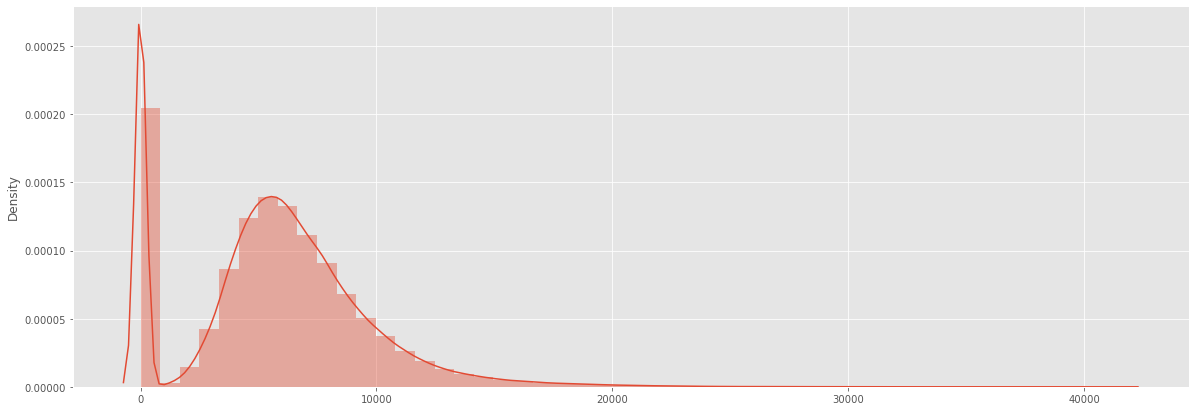

In [26]:
plt.figure(figsize=(20,7))
sns.distplot(df1['sales'].values);

Podemos observar que a sales está próximo de uma normal, tirando os zero.

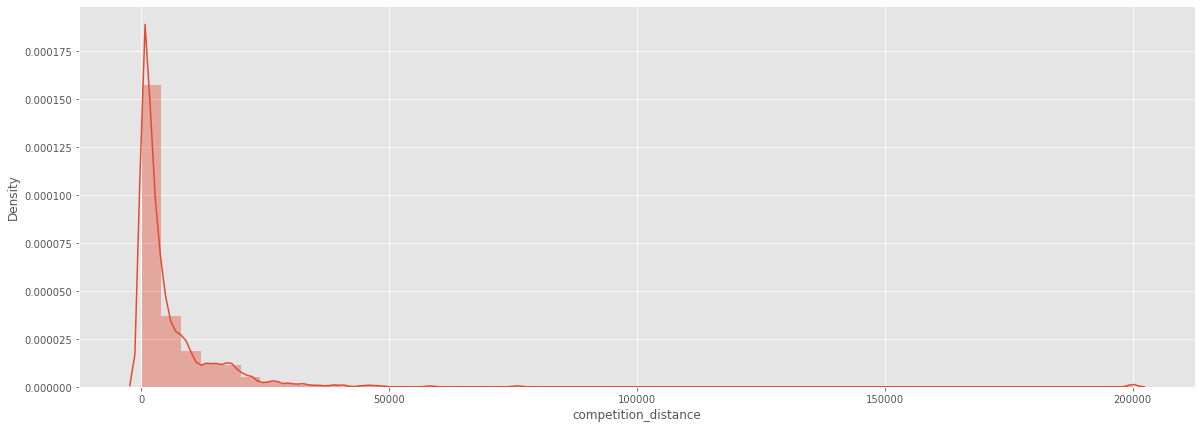

In [27]:
plt.figure(figsize=(20,7))
sns.distplot(df1['competition_distance']);

A competition_distance tem uma grande concentração de valor no começo, porque temos muitos competidores próximo um do outro, o gráfico parece com uma distribuição de poison. 

### 1.7.2. Categorical Attributes
Para as variáveis categórias vamos utilizar o boxplot, com ele podemos observar divesas medidas como de tendencia central e dispensão em um lugar. 

Antes vamos dar uma olhada quantos níveis cada variável categoria tem:

In [28]:
cat_attribus.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Vamos analisar apenas as três primeiras.

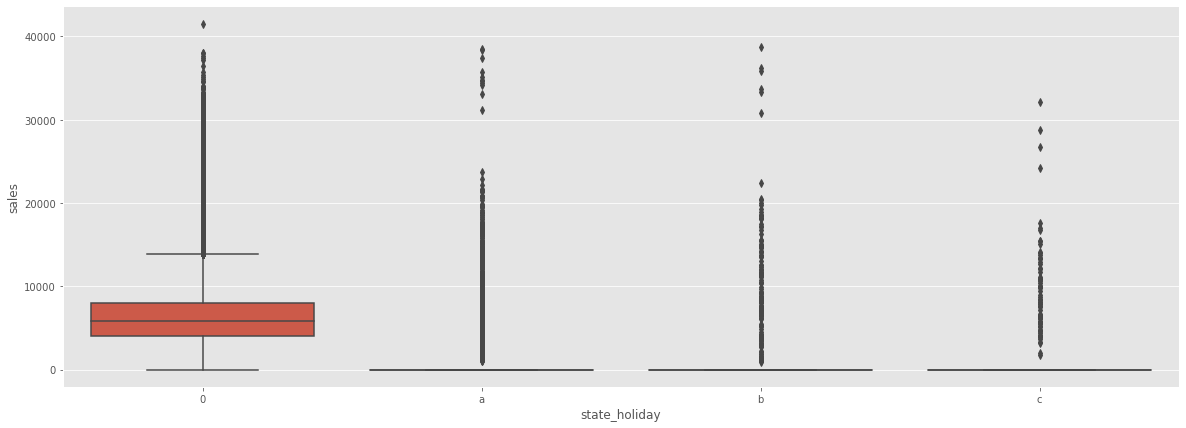

In [29]:
plt.figure(figsize=(20,7))
sns.boxplot(x='state_holiday', y= 'sales', data= df1);

Como podemos obsevar não conseguimos obsevar nada, porque nossos range estão muitos diferentes, isso é muito provável porque dias que as lojas estão fechadas e venda igual a zero que correspondem aos dias que as lojas estavam fechadas. 

Vamos fazer um filtro com a seguinte regra: 
- pegar apenas as lojas que abriram e que as vendas sejam maior que 0 (zero).

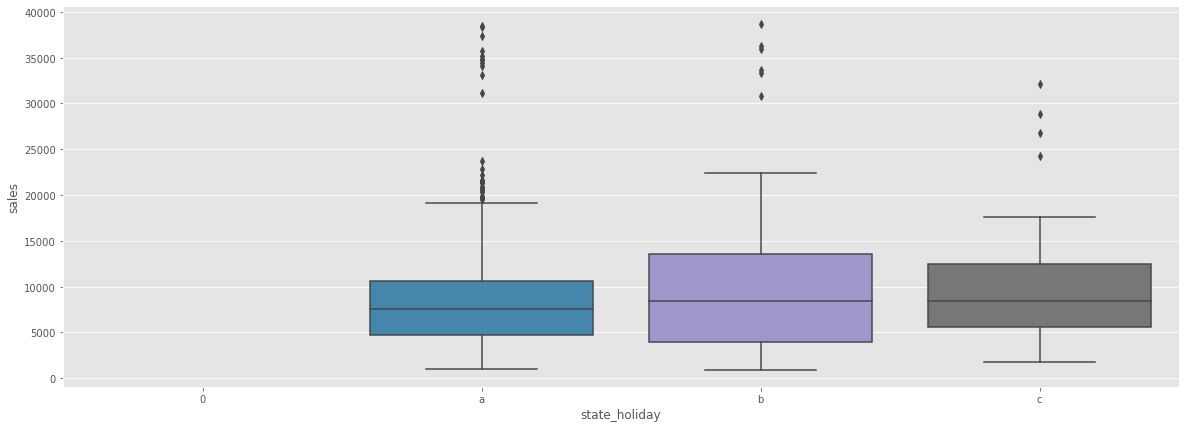

In [30]:
plt.figure(figsize=(20,7))
df1_aux = df1[(df1['state_holiday'] !='0' ) & (df1['sales'] >0 )]
sns.boxplot(x='state_holiday', y='sales', data=df1_aux);

Agora conseguimos ver alguma coisas, vamos plotar todas as variáveis uma do lado da outra: 

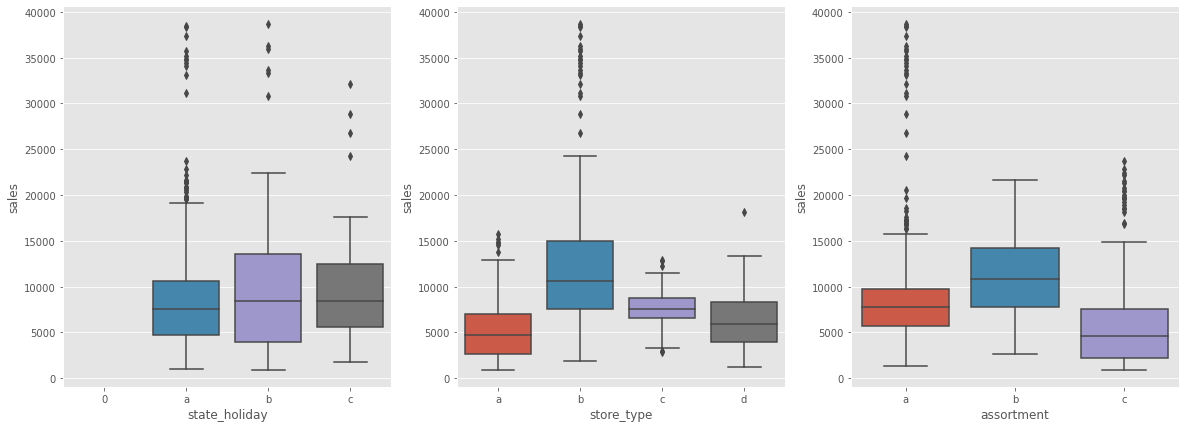

In [31]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=df1_aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=df1_aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=df1_aux);

**ANÁLISE** 

- **state_holiday**: No feriado do estado, o feriado **B** tem uma mediana maior que a do **A**, mas tem uma mediana muito parecida com ao do **C**, sendo que no **B** temos um equilíbrio de volume de vendas entre os  quartis 25 ao 75 em relação a mediana, enquanto ao feriado **C** temos uma maior concentração do quartil 50 ao 75;


- **store_type**: No tipo de loja, podemos observar que o tipo **B** tem um maior volume de venda em relação aos outros tipos, com muitos outliers e o volume não está em torno da mediana;


- **assortment**: No assortimento **B** tem um volume de venda maior que os outros assortimento, sendo que temos muitos outliers nos assortments **A** e **C**.

In [32]:
for col in (df1.select_dtypes('object')).columns:
    df1[col] = df1[col].astype('category')
  
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

In [33]:
df1.drop('promo_interval', axis=1).to_parquet('Db/df1.gzip', compression='gzip')

In [34]:
df2 = pd.read_parquet('Db/df1.gzip')
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,Jul,0


# 2.0. PASSO 02 - FETUARE ENGINEERING

## 2.1. Mapa Mental de Hipóteses.

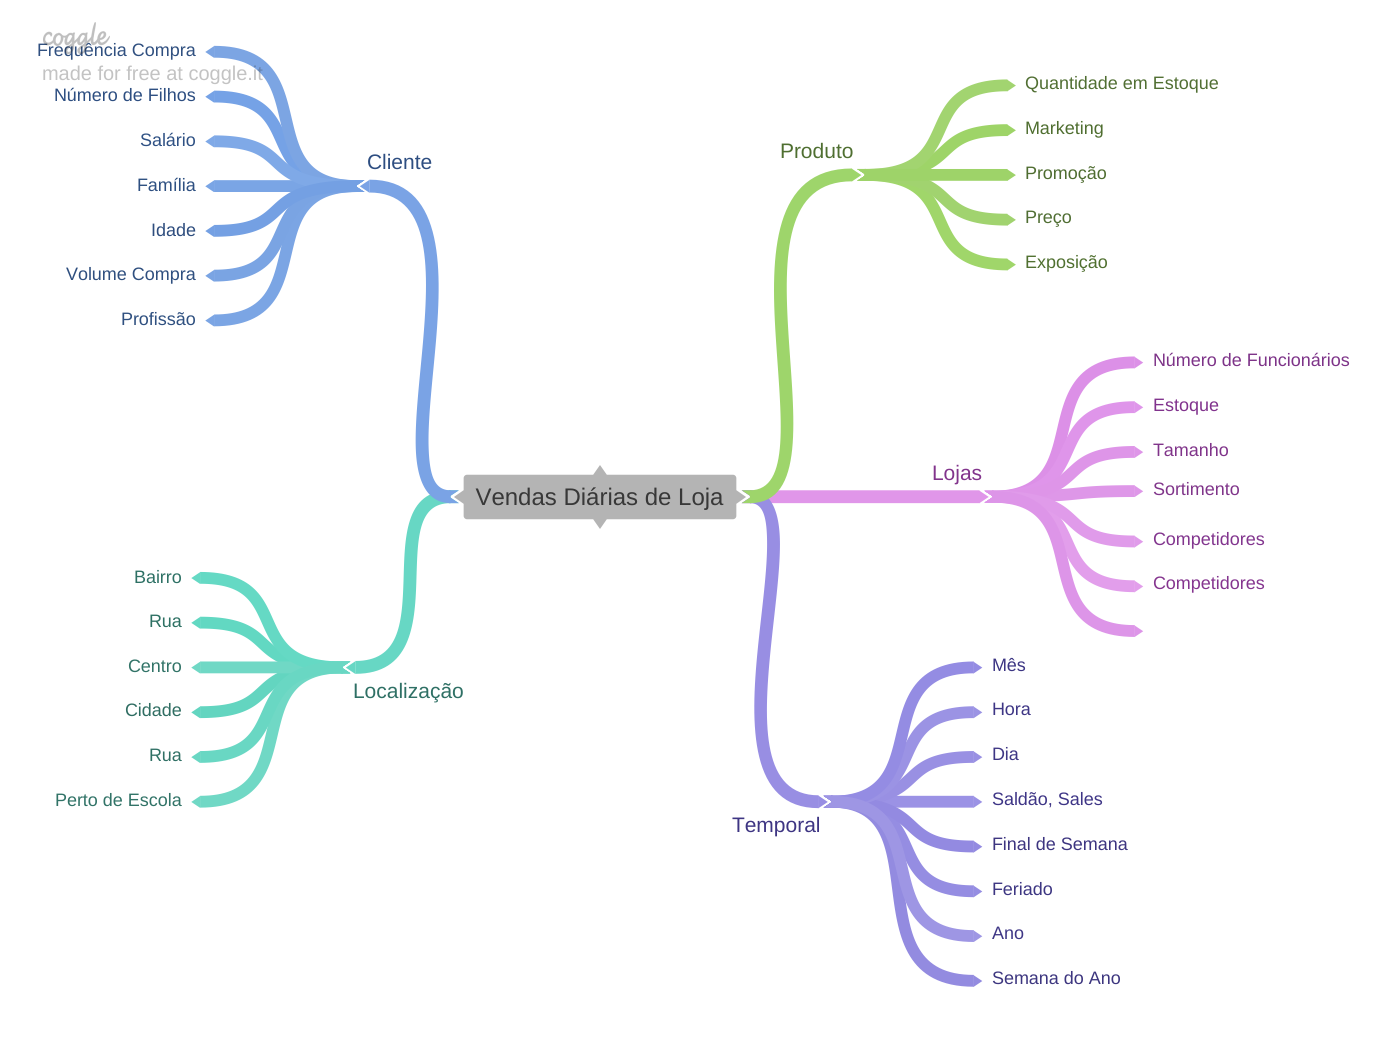

In [60]:
Image('img/MindMapHyphotesis.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Hipoteses Lojas

**1.** Lojas com maior número de funcionário deveriam vender mais; 

**2.** Lojas com maior estoque deveriam vener mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com menor porte deveriam vender menos;

**5.** Lojas com menor sortimento deveriam vender menos;

### 2.2.3. Hipoteses Produto

**1.** Loja que investe em Marketing deveriam vender mais;

**2.** Loja que expoem mais os produtos nas vitrines deveriam vender mais; 

**3.** Loja que tem presos nemores nos produtos deveriam vender mais;

**4.** Loja que tem presos menores por mais tempo nos produtos deveriam vender mais; 

**5.** Loja com promoções ativas por mais tempo deveriam vender mais;

**6.** Loja com mais dias de promoção deveriam vender mais; 

**7.** Loja com mais promoções consectivas deveriam vender mais. 


### 2.2.3. Hipoteses Tempo

**1.** Loja abertas diáriamente e feriados de Natal deveriam vender mais;

**2.** Loja deveriam vender mais ao longo do ano;

**3.** Loja deveriam vender mais no segundo semestre do ano;

**4.** Loja deveriam vender mais depois do dia 15 de cada mês;

**5.** Loja deveriam vender menos ao final de semana;

**6.** Loja deveriam vender menos durante ao feriado escolar;

### 2.3.4. Lista de Hipótese Final (Priorização)
Para a priorização de lista de hipótese final, o critério que vamos utilizar a existência de dados.

- **1.** Lojas com maior porte deveriam vender mais;
- **2.** Lojas com compeditores mais próximo deveriam vender menos;
- **3.** Lojas com compeditores à mais tempo deveriam vender mais;
- **4.** Loja com promoção ativa por mais tempo deveriam vender mais; 
- **5.** Lojas com mais dias de promoção deveriam vender mias;
- **7.** Lojas commais promoções consectivas deveriam vender mias;
- **8.** Lojas abetas durante o feriado de Natal deveriam vender mais;
- **9.** Lojas deveriam vender mais ao logo dos anos;
- **10.** Lojas deveriam vender mias no segundo semeste do ano;
- **11.** Lojas deveriam vender mias depois do dia 10 de cada mês;
- **12.** Lojas deveriam vendermenos aos finais de semana;
- **13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [36]:
df2['year']         = df2['date'].dt.year                                  # year 
df2['month']        = df2['date'].dt.month                                 # month  
df2['day']          = df2['date'].dt.day                                   # day
df2['week_of_year'] = df2['date'].apply(lambda x: x.weekofyear)            # week of year
df2['year_week']    = df2['date'].dt.strftime('%Y-%W').astype('category')  # year week

# competition since 
df2['competition_since']      = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], \
                                                                      month = x['competition_open_since_month'], day=1), axis=1) 
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')  

# promo since 
df2['promo_since']     = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) 
df2['promo_since']     = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - \
                                                  datetime.timedelta(days=7) )

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7 ).apply(lambda x: x.days).astype('int64')

# assortiment 
df2['assortment']      = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended').astype('category')

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'easter holiday' \
                                                  if x=='b' else 'cristimas' if x=='c' else 'regular day').astype('category')

df2.sample(5).T

,757788,792888,593932,337033,927174
store,374,909,423,733,280
day_of_week,3,7,3,1,5
date,2013-08-21 00:00:00,2013-07-21 00:00:00,2014-01-15 00:00:00,2014-09-15 00:00:00,2013-03-22 00:00:00
sales,6387,0,7641,15303,6464
customers,814,0,1418,3630,519
open,1,0,1,1,1
promo,0,0,0,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,0,0,0,0,0
store_type,a,a,b,b,d


Vamos salvar o dataset que trabalhamos até esse ponto. 

In [37]:
df2.to_parquet('Db/df2.gzip', compression='gzip')

In [38]:
df3 = pd.read_parquet('Db/df2.gzip')

In [39]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

# 3.0. PÁSSO 03 - Filtrando Variáveis
Neste passo a filtragem de variáveis é em relação as restrições de negócios, por exemplo podemos ter variáveis que no dataset temos, mas no momento da predição não vamos ter, neste caso podemos destacar a variável **customers**. 

## 3.1. Filtragem das linhas 
Vamos excluir as filias que estão fechadas com vendas zeradas.

In [40]:
df3 = df3[(df3['open']!=0) & (df3['sales']> 0)]

## 3.2. Seleção das colunas

In [41]:
cols_drop = ['customers', 'open', 'month_map']
df3       = df3.drop(cols_drop, axis =1)

In [43]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int64         
 1   day_of_week                   844338 non-null  int64         
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   promo                         844338 non-null  int64         
 5   state_holiday                 844338 non-null  category      
 6   school_holiday                844338 non-null  int64         
 7   store_type                    844338 non-null  category      
 8   assortment                    844338 non-null  category      
 9   competition_distance          844338 non-null  float64       
 10  competition_open_since_month  844338 non-null  int64         
 11  competition_

# 4.0. PASSO 04 - Análise Exploratória de Dados (EDA)

O objetivo da Análise Exploratória de Dados é para medir o impacto das variáveis em relação a variável resposta, assim conseguimos quantificar esse impacto. Ao fazermos a análise exploratorica dos dados ganho noções de como as variáveis se comportam e passarmos a ter uma noção das variáveis impactam o fenomeno, podemos destar 3 objetivos com a EDA: 

1. Ganhar experiencia de Negócio; 

2. Validar Hipóteses de Negócio. (Insights);

3. Perceber Variáveis que são importantes para o Modelo.


A EDA é constituídas de 3 (três) de tipos de análises: 

**1. Análise Univariada**: onde nos importamos apenas com uma única variável por vez, analisando como que a variável se comporta (min, max, distribuição, range, ...);

**2. Análise Bivariada**: é análise de como a variável impacta a variável resposta, neste caso, podemos utilizar correlação, validação das Hipóteses, etc;

**3. Análise Multivariada**: aqui analisamos como diversas variáveis se comporta em relação a variável resposta e entre elas, porque no fundo as aviáveis se relacionam.  

In [44]:
df4 = df3.copy()

## 4.1. Análise Univariada 

### 4.1.1. Response Variable

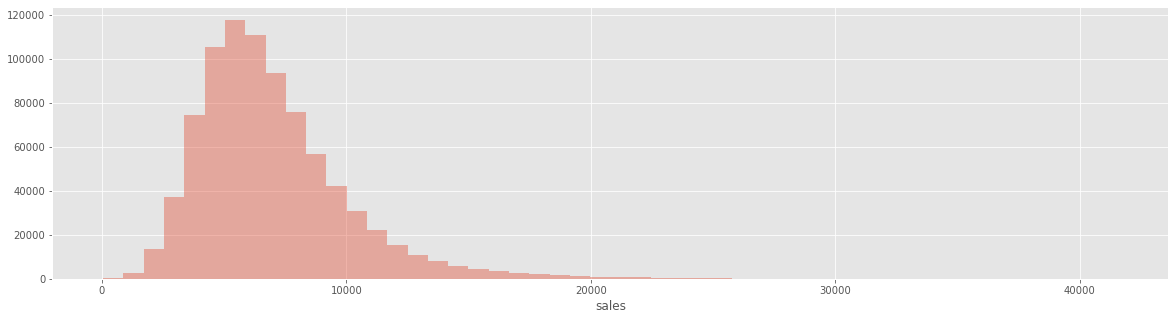

In [45]:
plt.figure(figsize=(20,5))
sns.distplot(df4['sales'], kde=False);

Podemos observar que o gráfico acima parece ter uma distribuição próxima a normal com uma skew positiva, porém não está centrada, devemos nos importar com isso porque os algoritmos de Michine Learning são criado com algumas premissas, que podemos destar como: que os dados sejam idependentes e normalmente distribuídos para ter uma melhor performance de predição, sendo assim, podemos fazer algumas transformações. 

Vamos fazer uma transformação de log que é muito utilizada em geral:

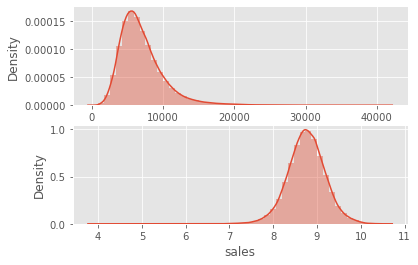

In [46]:
#plt.figure(figsize=(20,5))

plt.subplot(2,1,1)
sns.distplot(df4['sales'])

plt.subplot(2,1,2)
sns.distplot(np.log1p(df4['sales']));

Podemos observar que deu uma deslocada para a direita e que agora parece está mais próximo de uma normal, existe outras transformações que podemos utilizar com Box-Cox, exponencial, etc, que dependente do  

### 4.1.3. Numerical Variable

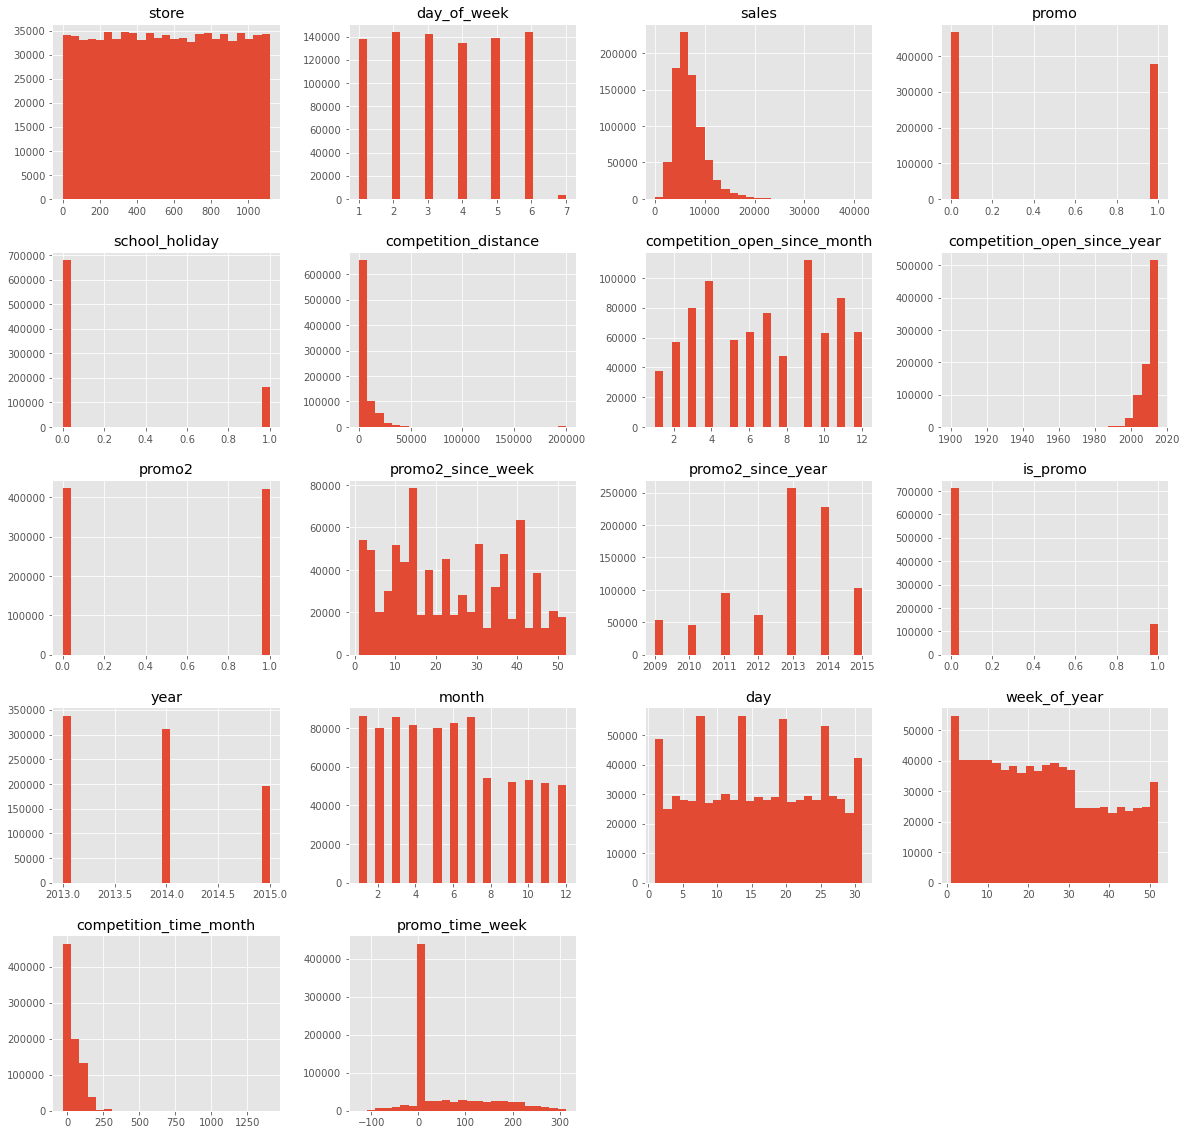

In [47]:
df4.select_dtypes(np.number).hist(bins=25, figsize=(20,20));

- **competition_distance**: observamos que temos uma concentração maior entre competidores com distância menores, isso quer dizer que todos os competidores estão muito próximos;


- **competition_open_since_month**: temos a distância que um competidor abriu em meses, obsevamos 


### 4.1.3. Categorical Variable

In [48]:
df4.select_dtypes('category').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

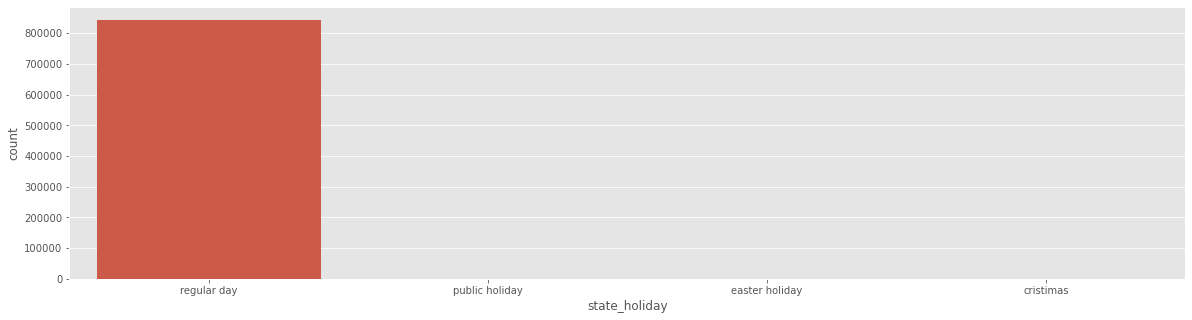

In [49]:
plt.figure(figsize=(20,5))
sns.countplot(df4['state_holiday']);

Observamos no gráfico acima que apenas o tipo de feriado que aparece é  **regular day**, que faz sentido, pois temos mais dias que não são feriados. 

Vamos fazer um filtro:

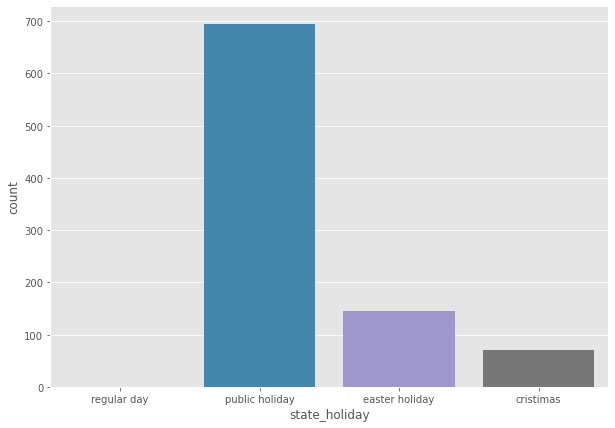

In [50]:
plt.figure(figsize=(10,7))
aux = df4[df4['state_holiday'] != 'regular day']
sns.countplot(aux['state_holiday']);

Agora observamos os três feriados principais, vamos analisar o **public holiday** que tem a maior concentração de vendas.

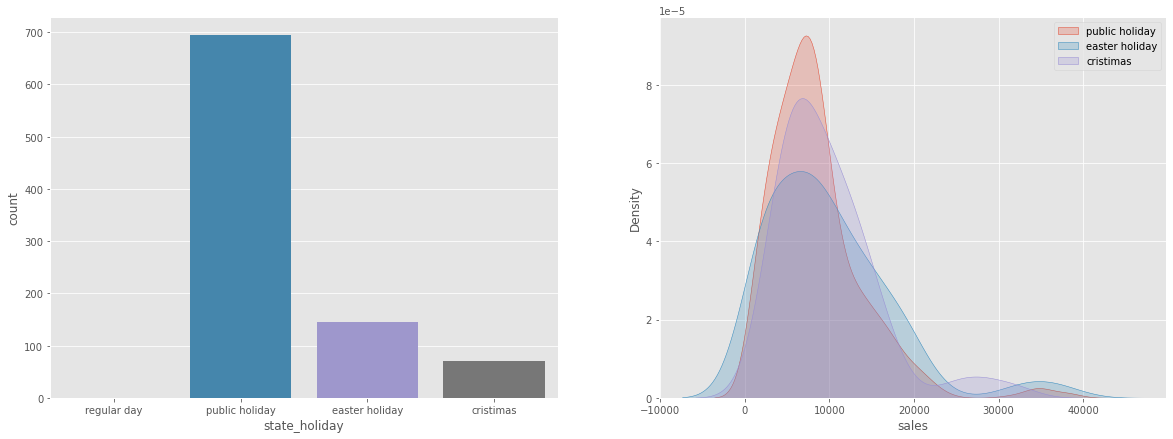

In [51]:
plt.figure(figsize=(20,7))

aux = df4[df4['state_holiday']!='regular day']

plt.subplot(1,2,1)
sns.countplot(aux['state_holiday']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public holiday']['sales'], label='public holiday', shade=True );
sns.kdeplot(df4[df4['state_holiday']=='easter holiday']['sales'], label='easter holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday']=='cristimas']['sales'], label='cristimas', shade=True );
  
plt.legend();

O public_holiday tem um volume maior de vendas, o cristimas tem um pico maior que easter, aqui temos informações importante, provavelmente essa variável é importante para o modelo, pois quando estiver passando por um dos feriados o modelo vai saber dimencionar esse volume.

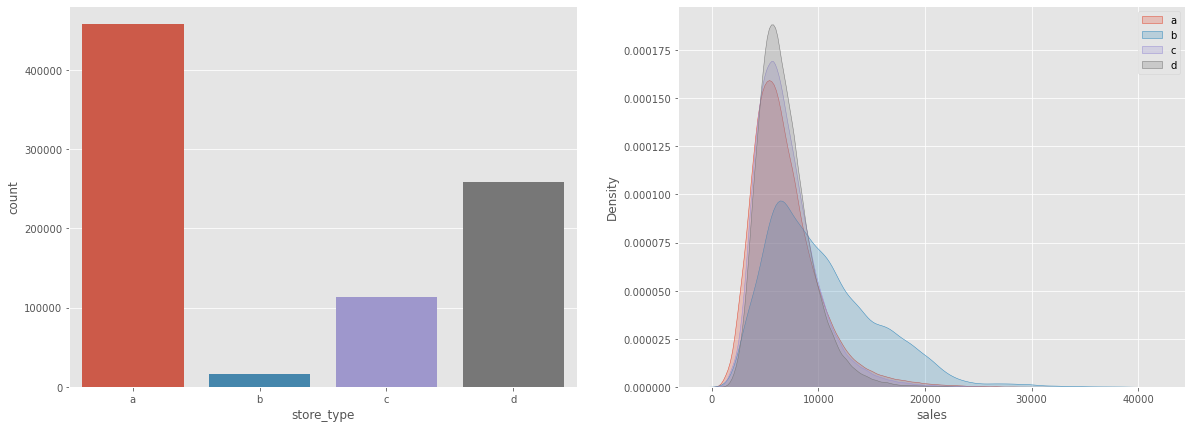

In [57]:
plt.figure(figsize=(20,7))

aux = df4 #[df4['state_holiday']!='regular day']

plt.subplot(1,2,1)
sns.countplot(aux['store_type']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True );
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True );
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True );
  
plt.legend();

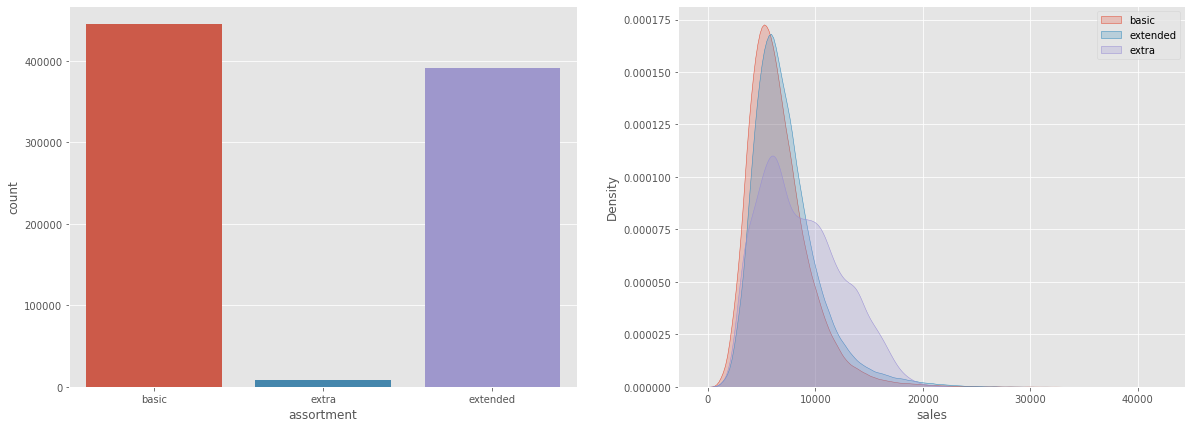

In [59]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.countplot(df4['assortment']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment']=='basic']['sales']   , label='basic', shade=True );
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment']=='extra']['sales']   , label='extra', shade=True );
  
plt.legend();

## 4.2. Análise Bivariada
Nesta seção vamos validar as nossas hipóteses.

### **H1.** Lojas com maior porte deveriam vender mais?

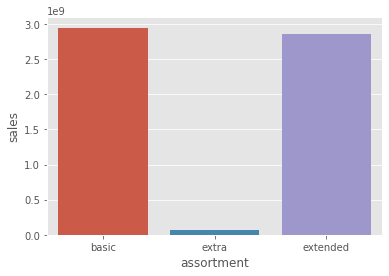

In [111]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

O que podemos concluiur no gráficos acima é que o basic e exended tem o mesmo volume de vendas, sendo assim, podemos ter um insight em relação sobre a hipótese (lojas com maior porte deveriam vender mais) e neste caso isso não acontece, uma observação importante é que essa afirmativa é em relação o que temos em relação a descrição dos dados e podemos invalidar a hipótese. 

Será que houve uma mudança ao longo do tempo em relação ao extra? 



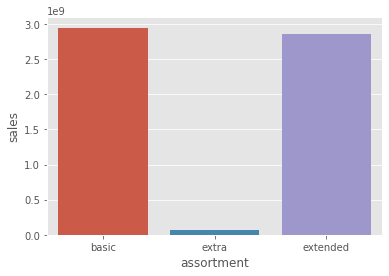

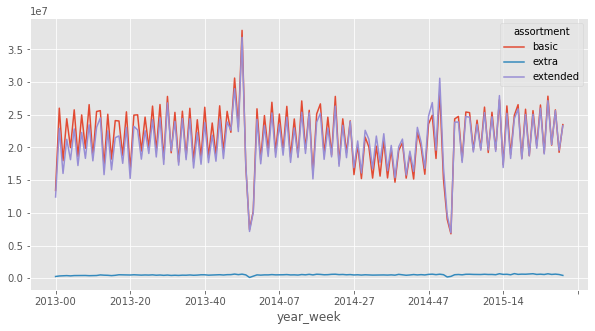

In [102]:

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(10,5));

No gráfica acima temos todas as vendas por ano e semana de todos os tipos de assortment, podemos concluir que basic e extended tem o mesmo comportamento, em relação ao extra não consigo visualizar o comportamento por o volume de venda dos outros dois assortment é muito grande puxando a escala para cima, vamos fazer um novo gráfico para analisar o comportamento do extra.

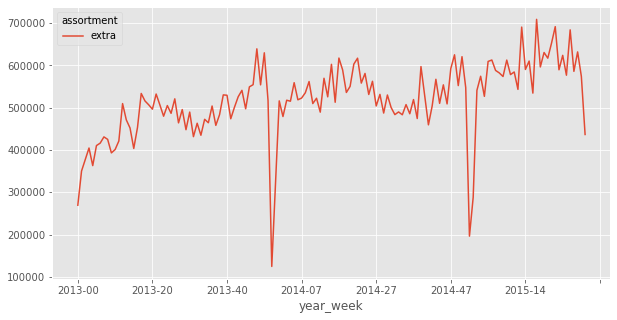

In [110]:
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(10,5));

Podemos observa que o extra tem um comportamento que não é linear como observamos no gráfico anterior. 

**Observações:**
1. lojas com maior sortimentos vende menos;
2. Segundo ponte olhando para a modelagem, essa variável parece ser importante, mesmo base e extended sendo iguais, pois quando o modelo aprender o comportamento do base e extended ele vai entender um comportamento bem similar, mas quando colocarmos algumas vendas com o tipo extra que tem um comportamento diferente com um volume menor e uma sazonalidade bem diferente.

### **H2.** Lojas com compeditores mais próximo deveriam vender menos?


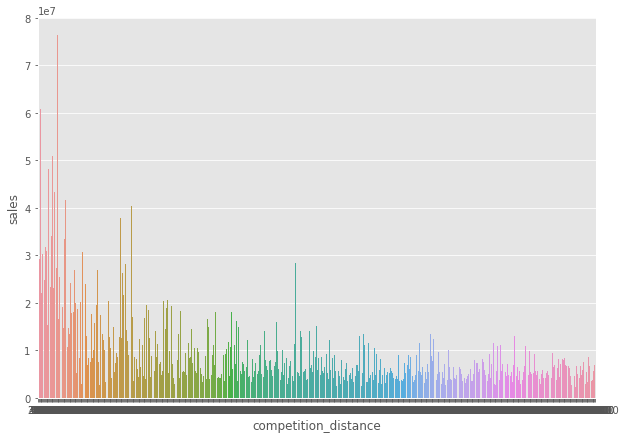

In [118]:
aux1 =  df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

plt.figure(figsize=(10,7))
sns.barplot(x='competition_distance', y='sales', data=aux1);

Observamos que temos um gráfivo muito granular, não dar para ver nada muito difícil de olhar, vamos criar alguns grupos com os **bins**. 

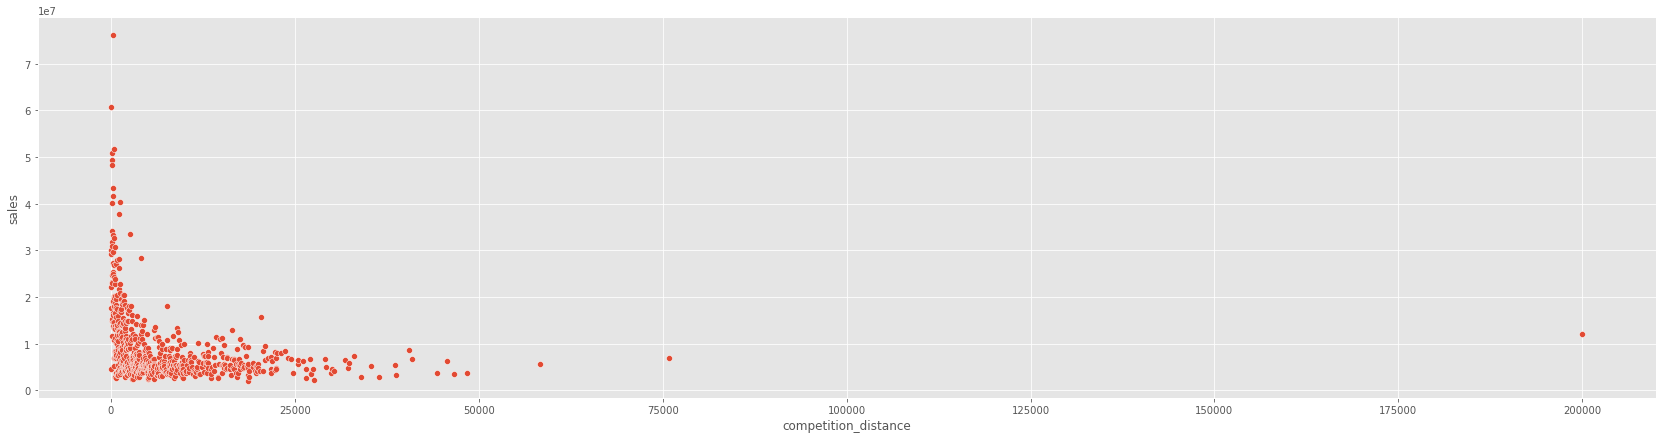

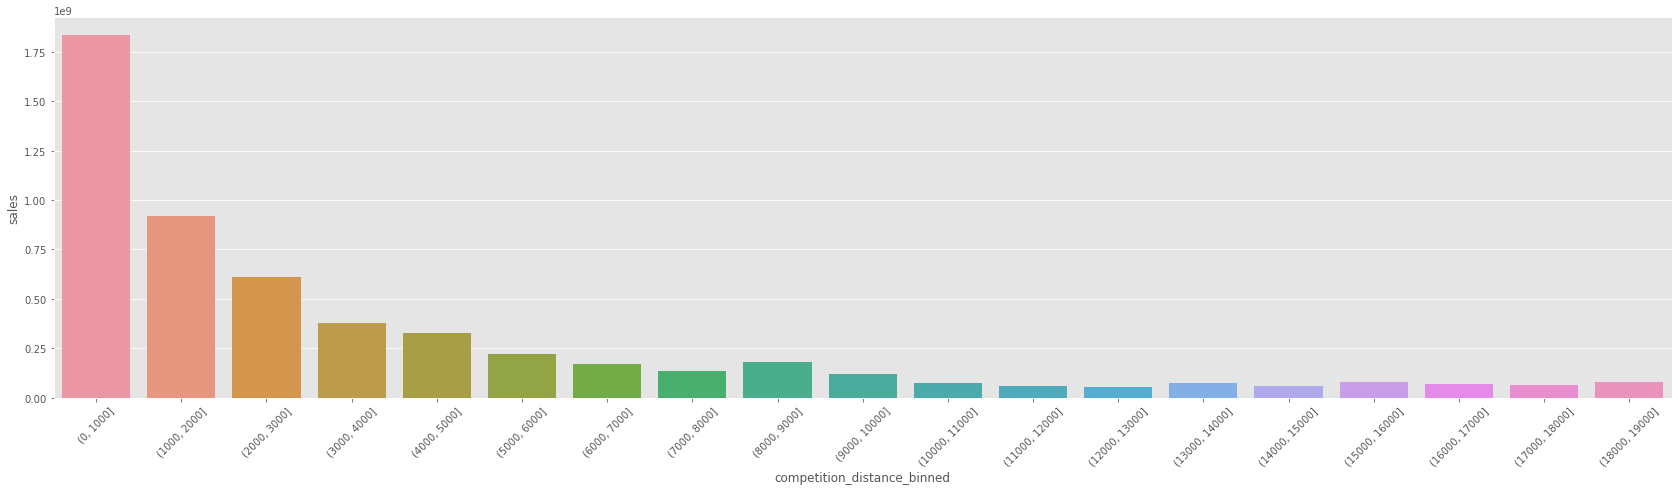

In [139]:
aux1 =  df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] =  pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby(['competition_distance_binned']).sum().reset_index()

plt.figure(figsize=(29,7))
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.figure(figsize=(29,7))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=45);


Agora conseguimos fazer uma analise. 

Olhando os gráficod acima obsevamos que lojas com mais competidores mais próximo vendem mais isso é um insight, pois invalida a hipótese de que lojas com mais competidores mais próximo vendem menos. 

Vamos olhar a relação da competition_distance em relação as vendas, isto é, medir a correção dessas duas variáveis.

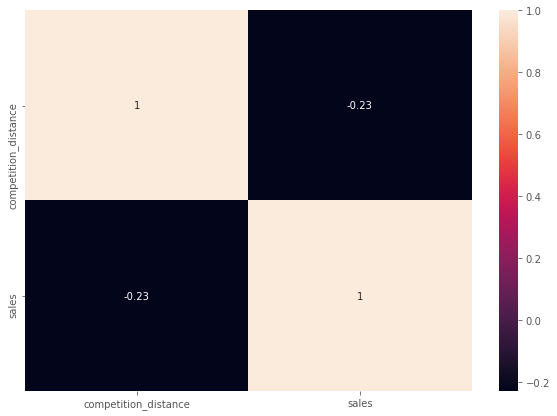

In [133]:
plt.figure(figsize=(10,7))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

É um correlação baixa, que indica que mais distante o meu concorrente menor é a venda. 

### **H3.** Lojas com compeditores à mais tempo deveriam vender mais?

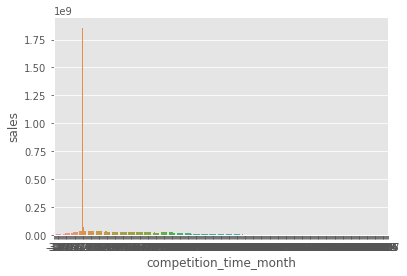

In [143]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
sns.barplot(x='competition_time_month', y='sales', data=aux1);

Não dar para ver nada, vamos fazer um filtro

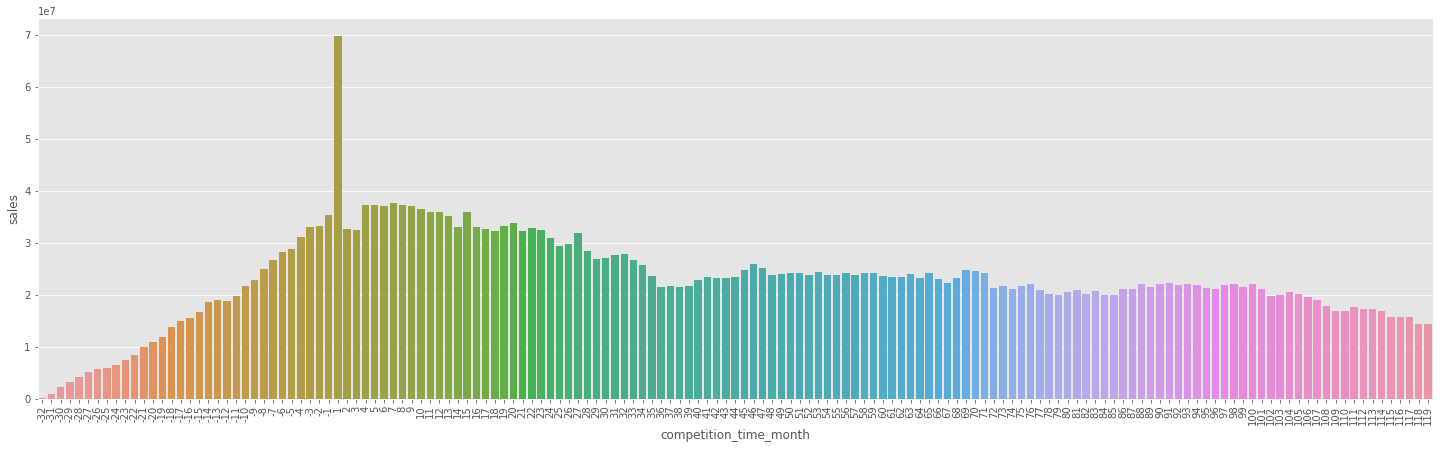

In [157]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)  & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25, 7))
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

Quando mais o valor vai se aproximando de zero, maior é a quantidade de venda, isso segnifica que quando mais for recente a abertura de um corrente maior será a venda, com isso conseguimos invalidar a hipótese de que quanto mais tempo temos um concorrente maior seria a nossa vendas, o que na verdade é o contrário.     

Vamos medir a força da correlação.

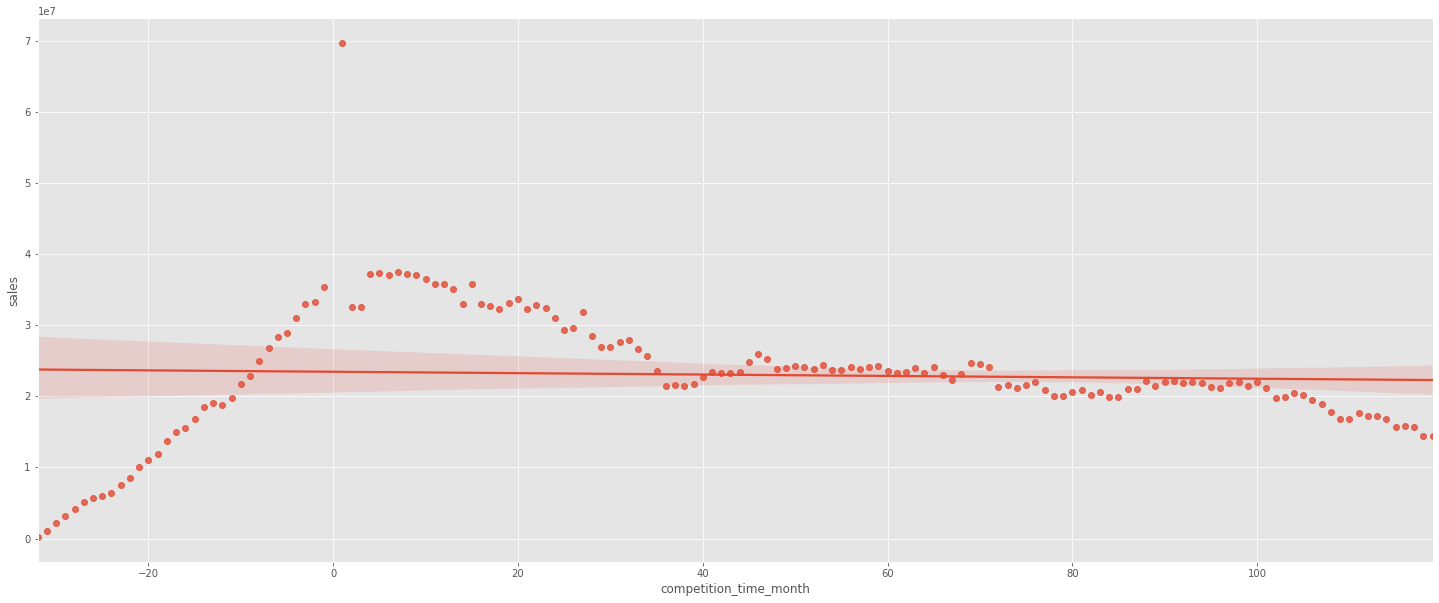

In [161]:
plt.figure(figsize=(25, 10))
sns.regplot(x='competition_time_month', y='sales', data=aux2);

Com linha de tendência podemos obsevar um ligeira queda das vendas ao longo do tempo, vamos olhar a correlação.

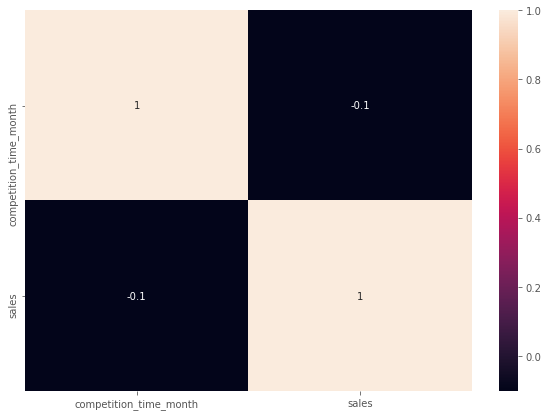

In [162]:
plt.figure(figsize=(10,7))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Temos uma correlação bem baixa, isso em temos de relevância para o modelo será um variável importante. 

## 4.3. Análise Multivariada

- https://github.com/snowcement/RossmannStoreSales/blob/master/Rossmann%20Store%20Sales.ipynb
- https://solgirouard.github.io/Rossmann_CS109A/
- https://medium.com/kaggle-blog/rossmann-store-sales-winners-interview-1st-place-gert-jacobusse-a14b271659b
- http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html
- https://github.com/entron/entity-embedding-rossmann

In [ ]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

In [ ]:
a = df4.select_dtypes(np.number).copy()

X = 

In [ ]:
fitting(X, y, criterion, splitter, mdepth, clweight, minleaf)